In [1]:
%matplotlib inline

# ensure that any edits to libraries
# are reloaded automatically
%reload_ext autoreload
%autoreload 2

In [2]:
# make survos2 importable
import sys
sys.path.append("./..")

lets import the relavent functions

In [3]:
from cuda_slic.slic import slic3d as cuda_slic

In [4]:
import numpy as np
from skimage import data, color, filters, segmentation
from skimage.util import img_as_float32, img_as_float64
from skimage.segmentation import slic as sk_slic
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
from ipywidgets import interact

Comparing speed between cuda-slic and skslic

cuda_slic took:
708 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
sk_slic took:


/scratch/ovs72384/anaconda3/envs/gpu-slic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


1.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/scratch/ovs72384/anaconda3/envs/gpu-slic/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  


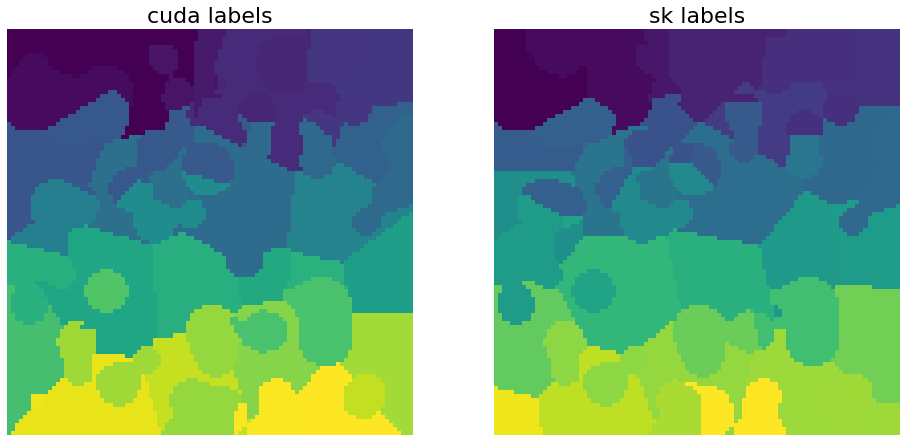

In [5]:
# initializing a 3 dim dataset

blob = data.binary_blobs(length=100, n_dim=3, seed=2)
blob = np.float32(blob)


print("cuda_slic took:")
%timeit -n1 -r1 cuda_labels = cuda_slic(blob, n_segments=300**2, compactness=0.5)
cuda_labels = cuda_slic(blob, n_segments=200, compactness=.5)

#blob = img_as_float64(blob)
print("sk_slic took:")
%timeit -n1 -r1 sk_labels = sk_slic(blob, n_segments=200, compactness=.5,  multichannel=False)
sk_labels = sk_slic(blob, n_segments=200, compactness=1,  multichannel=False)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.imshow(cuda_labels[:,:,0]); ax1.axis("off"); ax1.set_title("cuda labels", size=22);
ax2.imshow(sk_labels[...,0]); ax2.axis("off"); ax2.set_title("sk labels", size=22);

lets explore the segmentation of the whole 3D array

In [6]:
marked_cuda = mark_boundaries(color.gray2rgb(blob), cuda_labels)
marked_sk = mark_boundaries(color.gray2rgb(blob), sk_labels)

In [69]:
def plot_slice(images, z, cols=2, ax_size=5, titles=None):
    rows = (len(images)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*ax_size, rows*ax_size))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i in range(len(images)):
        axes[i].imshow(images[i][:,:,z])
        if titles:
            axes[i].set_title(titles[i], size=32)
    plt.tight_layout()

In [70]:
from ipywidgets import IntSlider, fixed
interact(plot_slice,
         images=fixed([cuda_labels, marked_cuda, sk_labels, marked_sk]),
         titles=fixed(None),
         z=IntSlider(min=0, max=99),
         ax_size=(2,20),
         cols=(1,6));

interactive(children=(IntSlider(value=0, description='z', max=99), IntSlider(value=2, description='cols', max=…

exploring the `n_segments` parameter and `compactness` parameter for cuda_slic and sk_slic

In [56]:
blob = data.binary_blobs(length=100, n_dim=3, seed=2)
blob = filters.gaussian(blob)
blob = blob[:,:,:10]
#blob = filters.gaussian(blob)
blob = np.float32(blob)

In [57]:
def compare_slic_algos(cuda_c, sk_c, n_segments=100, z=0):
    cuda_labels = cuda_slic(blob, n_segments=n_segments, compactness=cuda_c, postprocess=True)
    sk_labels = sk_slic(blob, n_segments=n_segments, compactness=sk_c, multichannel=False)
    marked_blob_cuda = mark_boundaries(color.gray2rgb(blob), cuda_labels, color=(0.2, 1, 0))
    marked_blob_sk = mark_boundaries(color.gray2rgb(blob), sk_labels, color=(1, 0.7, 0))
    plot_slice([cuda_labels, sk_labels, marked_blob_cuda, marked_blob_sk,],
               z=z,
               ax_size=6,
               titles=["cuda-slic", "skimage-slic", "cuda-slic", "skimage-slic"])

In [58]:
interact(compare_slic_algos,
         cuda_c=(0.001,5.0,0.01),
         sk_c=(0.001,5.0,0.001),
         n_segments=(5,500),
         z=IntSlider(min=0, max=9));

interactive(children=(FloatSlider(value=2.491, description='cuda_c', max=5.0, min=0.001, step=0.01), FloatSlid…

## Cuda SLIC Failiure Modes
From playing around with the parameters I was able to discover a few inputs that causes the cuda_slic algorithm to throw an error.

In [31]:
RUN_TESTS = True

### 1. input array (500, 500, 500), nps>50_000, compactness=30:

This usually throughs a `LogicError` exception. When it fails, it leaves memory residue in the GPU that is not cleaned up unless you terminate the pyhton process. 

This error is sometimes generated from the cuda compilation step of the `ccl.py` and sometimes form `slic.py`

Further complicating things the algorithm does not fail reliably with these inputs!!
However, I was able to make it fail reliably with `nps=500_000`. This indicates that the failiure rate is related to the the `nps` parameter.


In [32]:
if RUN_TESTS:
    blob = data.binary_blobs(length=600, n_dim=3, seed=2)
    blob = np.float32(blob)
    cuda_labels = cuda_slic(blob, n_segments=5_000_000, compactness=0.5)
    print(len(np.unique(cuda_labels)))

3338303



```
---------------------------------------------------------------------------
LogicError                                Traceback (most recent call last)
<ipython-input-39-ad381aadb072> in <module>
      1 blob = data.binary_blobs(length=500, n_dim=3, seed=2)
      2 blob = img_as_float32(blob)
----> 3 cuda_labels = cuda_slic(blob, nsp=50_000, compactness=30)
      4 print(len(np.unique(cuda_labels)))

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/cuda.py in wrapper(keep_gpu, *args, **kwargs)
     37     @wraps(func)
     38     def wrapper(*args, keep_gpu=False, **kwargs):
---> 39         r = func(*args, **kwargs)
     40         return asgpuarray(r, dtype) if keep_gpu else asnparray(r, dtype)
     41     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/slic.py in slic3d(data, nsp, sp_shape, compactness, sigma, spacing, max_iter, postprocess)
     29 
     30     with open(op.join(__dirname__, 'kernels', 'slic3d.cu'), 'r') as f:
---> 31         _mod_conv = SourceModule(f.read())
     32         gpu_slic_init = _mod_conv.get_function('init_clusters')
     33         gpu_slic_expectation = _mod_conv.get_function('expectation')

/scratch/ovs72384/anaconda3/envs/gpu-slic/lib/python3.7/site-packages/pycuda/compiler.py in __init__(self, source, nvcc, options, keep, no_extern_c, arch, code, cache_dir, include_dirs)
    292 
    293         from pycuda.driver import module_from_buffer
--> 294         self.module = module_from_buffer(cubin)
    295 
    296         self._bind_module()

LogicError: cuModuleLoadDataEx failed: an illegal memory access was encountered -
```

Interestingly, `sk_slic` drops out and refuses to segment the array to more than 250_000 groups. For example

In [20]:
sk_labels = sk_slic(blob, n_segments=5_000_000, compactness=1)
print(len(np.unique(sk_labels))) #250000

360000




### 2. input array of size less than (32, 32, 32) fails with "`IndexError`: too many indices for array"

In [41]:
if RUN_TESTS:
    blob = data.binary_blobs(length=20, n_dim=3, seed=2)
    blob = np.float32(blob)
    cuda_labels = cuda_slic(blob, n_segments=10, compactness=0.5)
    print(len(np.unique(cuda_labels)))

8


```
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
<ipython-input-22-0316eb65c967> in <module>
      1 blob = data.binary_blobs(length=31, n_dim=3, seed=2)
      2 blob = img_as_float32(blob)
----> 3 cuda_labels = cuda_slic(blob, nsp=10, compactness=30)
      4 print(len(np.unique(cuda_labels)))

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/cuda.py in wrapper(keep_gpu, *args, **kwargs)
     37     @wraps(func)
     38     def wrapper(*args, keep_gpu=False, **kwargs):
---> 39         r = func(*args, **kwargs)
     40         return asgpuarray(r, dtype) if keep_gpu else asnparray(r, dtype)
     41     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/slic.py in slic3d(data, nsp, sp_shape, compactness, sigma, spacing, max_iter, postprocess)
     85     if postprocess:
     86         min_size = int(np.prod(_sp_shape) / 10.)
---> 87         r = merge_small(asnparray(data), r, min_size)
     88         binlab = np.bincount(r.ravel())
     89 

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(*args, **kwargs)
    517     @wraps(func)
    518     def wrapper(*args, **kwargs):
--> 519         r = func(*args, **kwargs)
    520         return r is None or asnparray(r, dtype=dtype)
    521     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/ccl.py in merge_small(data, labels, min_size, **kwargs)
     80         data = data[..., None]
     81     assert data.ndim == labels.ndim + 1
---> 82     return _merge_small3d(data, labels, labels.max()+1, min_size)
     83 
     84 

~/Projects/gpu-slic/survos2/improc/regions/_ccl.pyx in improc.superregions._ccl._merge_small3d()

IndexError: too many indices for array

```

In [27]:
## 3. lets check if the code is diterministic

In [43]:
if RUN_TESTS:
    blob = data.binary_blobs(length=50, n_dim=3, seed=2)
    blob = np.float32(blob)
    all_close = []
    for i in range(10):
        cuda_labels1 = cuda_slic(blob, n_segments=100, compactness=30)
        cuda_labels2 = cuda_slic(blob, n_segments=100, compactness=30)
        all_close.append((cuda_labels1 == cuda_labels2).all())
    print(all_close)

[True, True, True, True, True, True, True, True, True, True]


```
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
<ipython-input-38-af438af83248> in <module>
      4 cuda_labels2 = cuda_slic(blob, nsp=32, compactness=30)
      5 
----> 6 assert np.allclose(cuda_labels1, cuda_labels2)

AssertionError: 
```

as expected. This basically confirms to me that there are memory race errors in the code.

This is likely related to Faliure mode 1. as you expect data races not to raise errors under
ordinary circomstances.

## Performance Benchmarks
Performance characteristics can reveal important bugs in the code base. So lets see how `cuda_slic` and `sk_slic` compare.

Running these benchmarks uncovered errors when the cuda_slic functin is run consecutively with many different inputs.
This indicates that the GPU memory is retaining state from previous calls that cause a subsequent kernel calls to fail.

Lets keep a record of this data:

In [18]:
from pathlib import Path

# make `data` directory in notebooks if it does not exist
notebooks = Path(".")
dir_name = str(notebooks.absolute()).split("/")[-1]
if dir_name == "notebooks":
    (notebooks/"benchmarks").mkdir(exist_ok=True)
else:
    print("notebooks is not your current worknig directory")
[print(f) for f in notebooks.iterdir()];

.ipynb_checkpoints
exploring_slic3d.ipynb
benchmarks
numpy_notes.ipynb


In [12]:
import pandas as pd

In [13]:
DO_BENCHMARK = True
SAVE_BENCHMARK = False

def generate_benchmark():
    df = pd.DataFrame(columns=["bytes", "n_segments", "cuda_time", "skimage_time"])
    lengths = [100, 200, 300, 400, 500]
    #lengths = range(100, 450,30)
    for i in range(len(lengths)):
        row = []
        row.append(lengths[i]**3*4) #number of bytes to be processed
        n_segments = lengths[i]**3/3**3
        row.append(n_segments)
        blob = data.binary_blobs(length=lengths[i], n_dim=3, seed=2)
        blob = np.float32(blob)
        print(f"cuda time for length {lengths[i]}:")
        measurement1 = %timeit -n1 -r1 -o cuda_slic(blob, n_segments=n_segments, compactness=1)
        row.append(measurement1.average)
        print(f"skimage time for length {lengths[i]}:")
        measurement2 = %timeit -n1 -r1 -o sk_slic(blob, n_segments=n_segments, \
                                                  compactness=1, multichannel=False, \
                                                  max_iter=5)
        row.append(measurement2.average)
        df.loc[i] = row
    return df
if DO_BENCHMARK:
    df = generate_benchmark()

cuda time for length 100:
516 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 100:
1.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 200:
1.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 200:
9.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 300:
5.53 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 300:
31.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 400:
12.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 400:
1min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 500:
24.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 500:
2min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
print(df.skimage_time/df.cuda_time)

0    2.176428
1    5.378479
2    5.714384
3    5.762262
4    5.990205
dtype: float64


In [15]:
from datetime import datetime

d = datetime.now()
d.strftime("%d_%m_%Y")

'28_07_2020'

In [16]:
from datetime import datetime
SAVE_BENCHMARK = False
if SAVE_BENCHMARK:
    d = datetime.now()
    d = d.strftime("%d_%m_%Y")
    df.to_csv("benchmarks/slic_bench_{}.csv".format(d), index=False)

In [17]:
ndf = df.copy()

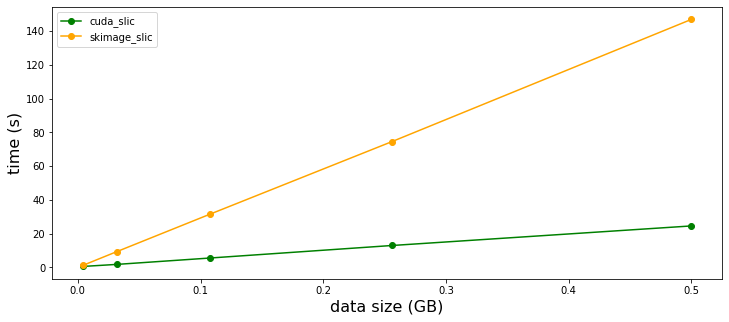

In [18]:
ndf["g_bytes"] = ndf["bytes"]/10**9

fig, ax = plt.subplots(1,1,figsize=(12,5))
plt.plot(ndf.g_bytes, ndf.cuda_time, color="green", marker="o", label="cuda_slic")

plt.plot(ndf.g_bytes, ndf.skimage_time, color="orange", marker="o", label="skimage_slic")
plt.xlabel("data size (GB)", size=16)
plt.ylabel("time (s)", size=16)
plt.legend()

In [19]:
slope_cuda = (ndf.cuda_time.iloc[-1] - ndf.cuda_time.iloc[0])/\
             (ndf.g_bytes.iloc[-1] - ndf.g_bytes.iloc[0])
slope_skimage = (ndf.skimage_time.iloc[-1] - ndf.skimage_time.iloc[0])/\
                (ndf.g_bytes.iloc[-1] - ndf.g_bytes.iloc[0])

In [20]:
print(slope_cuda);print(slope_skimage)

48.413201008975925
293.9754804031127


In [21]:
print("So cuda_slic is ~{:.2f}x faster than sk_slic.".format(slope_skimage/slope_cuda))

So cuda_slic is ~6.07x faster than sk_slic.


In [5]:
def cuda_benchmark():
    byte_sizes = []
    times = []
    lengths = range(100, 550,50)
    #lengths = [750]
    for i in range(len(lengths)):
        byte_size = lengths[i]**3*4
        byte_sizes.append(byte_size)
        n_segments = lengths[i]**3/10**3
        blob = data.binary_blobs(length=lengths[i], n_dim=3, seed=2)
        blob = np.float32(blob)
        print("input data now is {} MB".format(byte_size/10**6))
        measurement = %timeit -n1 -r1 -o cuda_slic(blob, n_segments=n_segments, compactness=1)
        times.append(measurement.average)
    return byte_sizes, times

b, t = cuda_benchmark()

input data now is 4.0 MB
795 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 13.5 MB
664 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 32.0 MB
1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 62.5 MB
2.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 108.0 MB
3.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 171.5 MB
5.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 256.0 MB
8.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 364.5 MB
11.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
input data now is 500.0 MB
19.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(b, t)
plt.plot([bb/10**9 for bb in b], t, color="green", marker="o")

### Profiling

In [59]:
!pip install line_profiler

In [60]:
%load_ext line_profiler

In [61]:
# initializing a 3 dim dataset
from survos2.improc.regions.slic import slic3d
blob = data.binary_blobs(length=300, n_dim=3, seed=2)
blob = np.float32(blob)

In [62]:

%lprun -f slic3d slic3d(blob, n_segments=300, compactness=0.5)

<pre>


Timer unit: 1e-06 s

Total time: 3.59489 s
File: ./../survos2/improc/regions/slic.py
Function: slic3d at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    24                                           def slic3d(image, n_segments=100, sp_shape=None, compactness=1.0, sigma=None,
    25                                                      spacing=(1,1,1), max_iter=5, postprocess=True):
    26                                               """
    27                                           
    28                                               """
    29         1          3.0      3.0      0.0      if image.ndim not in [3,4]:
    30                                                   raise ValueError(("input image must be either 3, or 4 dimention."
    31                                                                     "the image.ndim provided is {}".format(image.ndim)))
    32         1         13.0     13.0      0.0      dshape = np.array(image.shape[-3:])
    33                                           
    34         1       5837.0   5837.0      0.2      with open(op.join(__dirname__, 'kernels', 'slic3d.cu'), 'r') as f:
    35         1     150250.0 150250.0      4.2          _mod_conv = SourceModule(f.read())
    36         1         28.0     28.0      0.0          gpu_slic_init = _mod_conv.get_function('init_clusters')
    37         1          5.0      5.0      0.0          gpu_slic_expectation = _mod_conv.get_function('expectation')
    38         1         41.0     41.0      0.0          gpu_slic_maximization = _mod_conv.get_function('maximization')
    39                                           
    40         1          2.0      2.0      0.0      if sp_shape:
    41                                                   if isinstance(sp_shape, int):
    42                                                       _sp_shape = np.array([sp_shape, sp_shape, sp_shape])
    43                                                   
    44                                                   elif len(sp_shape) == 3 and isinstance(sp_shape, tuple):
    45                                                       _sp_shape = np.array(sp_shape)
    46                                                   else:
    47                                                       raise ValueError(("sp_shape must be scalar int or tuple of length 3"))
    48                                           
    49                                                   _sp_grid = (dshape + _sp_shape - 1) // _sp_shape
    50                                           
    51                                               else:
    52         1        177.0    177.0      0.0          sp_size = int(np.ceil((np.prod(dshape) / n_segments)**(1./3.)))
    53         1         21.0     21.0      0.0          _sp_shape = np.array([sp_size, sp_size, sp_size])
    54         1         25.0     25.0      0.0          _sp_grid = (dshape + _sp_shape - 1) // _sp_shape
    55                                           
    56         1         42.0     42.0      0.0      sp_shape = np.asarray(tuple(_sp_shape[::-1]), int3)
    57         1         10.0     10.0      0.0      sp_grid = np.asarray(tuple(_sp_grid[::-1]), int3)
    58                                           
    59         1         11.0     11.0      0.0      m = np.float32(compactness)
    60                                           
    61                                               # seems that changing this line fixed the memory leak issue
    62                                               # S = np.float32(np.prod(_sp_shape)**(1./3.))
    63         1         39.0     39.0      0.0      S = np.float32(np.max(_sp_shape))
    64                                           
    65                                               # should be correct according to Achanta 2012
    66                                               #S = np.float32(np.sqrt(np.prod(np.array(data.shape[:-1]))/n_segments))
    67                                           
    68         1         25.0     25.0      0.0      n_centers = np.int32(np.prod(_sp_grid))
    69         1          8.0      8.0      0.0      n_features = np.int32(image.shape[0] if image.ndim == 4 else 1)
    70         1         11.0     11.0      0.0      im_shape = np.asarray(tuple(dshape[::-1]), int3)
    71         1         14.0     14.0      0.0      spacing = np.asarray(tuple(spacing[::-1]), float3)
    72                                           
    73         1      15933.0  15933.0      0.4      data_gpu = asgpuarray(image, np.float32)
    74         1        540.0    540.0      0.0      centers_gpu = gpuarray.zeros((n_centers, n_features + 3), np.float32)
    75         1        444.0    444.0      0.0      labels_gpu = gpuarray.zeros(dshape, np.uint32)
    76                                           
    77         1         65.0     65.0      0.0      vblock, vgrid = flat_kernel_config(gpu_slic_init, dshape)
    78         1         23.0     23.0      0.0      cblock, cgrid = flat_kernel_config(gpu_slic_init, _sp_grid)
    79                                           
    80         1          2.0      2.0      0.0      gpu_slic_init(data_gpu, centers_gpu, n_centers, n_features,
    81         1        138.0    138.0      0.0          sp_grid, sp_shape, im_shape, block=cblock, grid=cgrid)
    82         1        660.0    660.0      0.0      cuda.Context.synchronize()
    83                                           
    84         6          8.0      1.3      0.0      for _ in range(max_iter):
    85         5          4.0      0.8      0.0          gpu_slic_expectation(data_gpu, centers_gpu, labels_gpu, m, S,
    86         5          3.0      0.6      0.0              n_centers, n_features, spacing, sp_grid, sp_shape, im_shape,
    87         5        344.0     68.8      0.0              block=vblock, grid=vgrid)
    88         5    2244361.0 448872.2     62.4          cuda.Context.synchronize()
    89                                           
    90         5         11.0      2.2      0.0          gpu_slic_maximization(data_gpu, labels_gpu, centers_gpu,
    91         5          5.0      1.0      0.0              n_centers, n_features, sp_grid, sp_shape, im_shape,
    92         5        394.0     78.8      0.0              block=cblock, grid=cgrid)
    93         5     690248.0 138049.6     19.2          cuda.Context.synchronize()
    94                                           
    95         1     165306.0 165306.0      4.6      r = ccl3d(labels_gpu, remap=True)
    96                                               # r = asnparray(labels_gpu, dtype=np.int)
    97                                           
    98                                               # labels = labels_gpu.get()
    99                                               # binlab = np.bincount(labels.ravel())
   100                                               # binlab = np.bincount(r.ravel())
   101                                           
   102         1          2.0      2.0      0.0      if postprocess:
   103                                                   # segment_size = np.prod(dshape)/n_centers
   104                                                   # min_size = int(0.2 * segment_size)
   105                                                   # max_size = int(3 * segment_size)
   106                                                   # r = _enforce_label_connectivity_cython(r, min_size, max_size, start_label=0)
   107         1         67.0     67.0      0.0          min_size = int(np.prod(_sp_shape) / 10.)
   108         1     319770.0 319770.0      8.9          r = merge_small(asnparray(image), asnparray(r), min_size)
   109                                                   # binlab = np.bincount(r.ravel())
   110                                           
   111         1          3.0      3.0      0.0      return r


</pre>